# RNNs for Text Classification

In [ ]:
# Imports
from IPython.display import clear_output
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import spacy
import re
import string
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Downloading the Spam SMS Dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

!unzip /content/smsspamcollection.zip
!rm /content/readme
!rm !rm /content/smsspamcollection.zip

clear_output()

In [ ]:
# Downloading the GloVe embeddings database

!wget https://nlp.stanford.edu/data/glove.6B.zip

!unzip /content/glove.6B.zip

!rm -rf /content/glove.6B.zip
!rm /content/glove.6B.100d.txt
!rm /content/glove.6B.200d.txt
!rm /content/glove.6B.300d.txt

clear_output()

In [ ]:
text = []
label = []

with open("/content/SMSSpamCollection") as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 2:
            label_text, message = parts
            if label_text.lower() == 'spam':
                label.append(1)
            else:
                label.append(0)
            text.append(message)

In [ ]:
# Creating a Pandas Dataframe
sms = pd.DataFrame(zip(text, label), columns = ["Text", "Label"])
sms['Text_Length'] = sms['Text'].apply(lambda x: len(x))

In [ ]:
# print(sms['Text'].shape)
# print(sms['Label'])

In [ ]:
spacy_tokenizer = spacy.load('en_core_web_sm')
def tokenize (text):
    doc = spacy_tokenizer(text)
    tokens = [token.text for token in doc if not token.is_punct and not token.is_space]
    tokens = [token.lower() for token in tokens]
    return tokens

In [ ]:
# Tokenize the text sms in the Pandas Dataframe
sms["Tokenized_Text"] = sms["Text"].apply(tokenize)

In [ ]:
def load_GloVe_embeddings(glove_file):
    embeddings_dict = {}
    with open(glove_file, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            embedding = np.array(values[1:], dtype='float32')
            embeddings_dict[word] = embedding
    return embeddings_dict

In [ ]:
def embed_text(tokenized_text, word_embeddings, max_text_length=20, embedding_size = 50):
    embedded_text = np.zeros((max_text_length, embedding_size), dtype=np.float32)
    for i, token in enumerate(tokenized_text[:max_text_length]):
        if token in word_embeddings.keys():
            embedded_text[i] = word_embeddings[token]

    return embedded_text

In [ ]:
# Initialize an empty list to store the embedded text
embedded_texts = []
word_embeddings = load_GloVe_embeddings('/content/glove.6B.50d.txt')
for tokenized_text in sms["Tokenized_Text"]:
    # Embed the tokenized text using pre-trained word embeddings
    embedded_text = embed_text(tokenized_text, word_embeddings)

    # Append the embedded text to the list
    embedded_texts.append(embedded_text)

sms["Embedded_Text"] = embedded_texts

In [ ]:
print(sms["Tokenized_Text"][0])

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']


In [ ]:
"""Complete the below code for the Dataloader class"""
class load_dataset(Dataset):
    def __init__(self, X, Y):
        """
            X: the embeddings of the sentence
            Y: ground truth of the sentence (0- positive, 1- negative)
        """
        self.X = X
        self.y = Y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        data = self.X[idx]
        label = self.y[idx]
        return data, label

In [ ]:
class RNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, num_layers=1, dropout = 0.5):
        """Define your layers, activation functions here"""
        super(RNN, self).__init__()
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """Perform a forward pass"""
        rnn_output, _ = self.rnn(x)
        rnn_output = self.dropout(rnn_output)
        output = self.fc(rnn_output[:, -1, :])
        output = self.sigmoid(output)

        return output

In [ ]:
def train_model(num_epochs, train_loader, model, criterion, optimizer):
    """
    Train the model.

    Parameters:
    - num_epochs (int): Number of epochs for training.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - model (nn.Module): Model to be trained.
    - criterion: Loss function.
    - optimizer: Optimizer for updating model parameters.
    """
    accuracy_history = []
    loss_history = []
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        epoch_loss = 0
        model.train()
        for inputs, labels in tqdm.tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            # Calculating the accuracy
            epoch_loss += loss.item()
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

        accuracy = correct / total * 100
        accuracy_history.append(accuracy)
        epoch_loss /= len(train_loader.dataset)  # normalize loss
        loss_history.append(epoch_loss)

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), accuracy_history, linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy History')
    plt.grid(True)
    plt.show()

    # Plot for loss history
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), loss_history, linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.grid(True)
    plt.show()

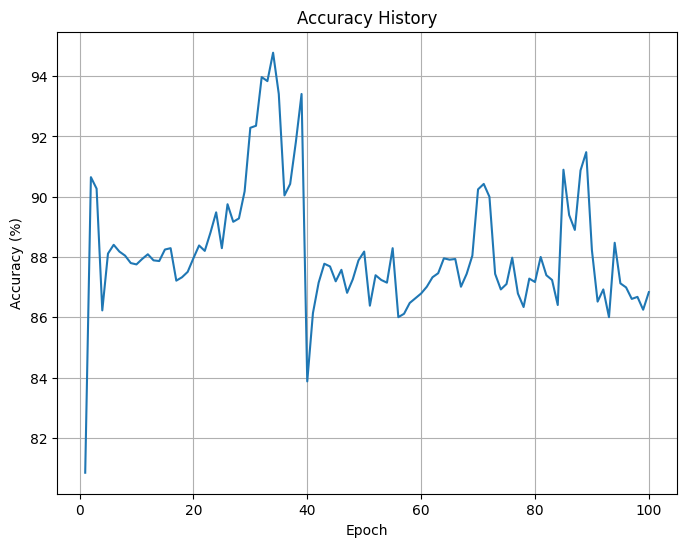

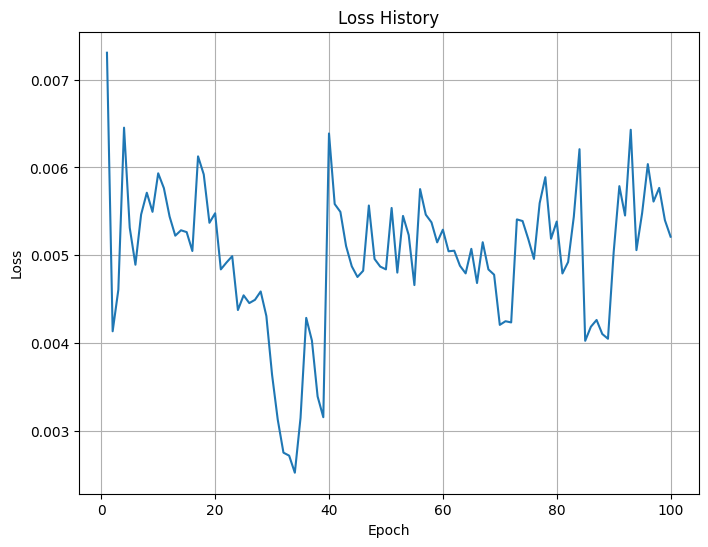

In [ ]:
"""
1. Write code to split your available data into training and testing splits
2. Define the model
3. Set up hyper-parameters such as learning rate, number of epochs, batch size
4. Train the model by using the function you defined above
5. Check the model accuracy by running the model on the testing split
6. Save the model as a .pth file
"""

###########YOUR CODE HERE###########
X = sms['Embedded_Text']
y = sms['Label']
X = torch.tensor(X)
y = torch.tensor(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = load_dataset(X_train, y_train)
test_dataset = load_dataset(X_test, y_test)

# Create DataLoader for training and testing sets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define hyperparameters
vocab_size = len(word_embeddings)

embedding_size = 50
hidden_size = 128
output_size = 1  # Binary classification
num_layers = 1
learning_rate = 0.01
num_epochs = 100

# Initialize the model and setting loss and optimizers
model = RNN(vocab_size, embedding_size, hidden_size, output_size, num_layers)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_model(num_epochs, train_loader, model, criterion, optimizer)

torch.save(model.state_dict(), 'rnn_sentiment_analysis.pth')

In [ ]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, labels.unsqueeze(1).float()).item()
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    test_loss /= len(test_loader.dataset)

    test_accuracy = correct / total * 100

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy

test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

Test Loss: 0.0049, Test Accuracy: 87.09%
